# import 

In [20]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json, html, re
import numpy as np
from tqdm import tqdm
from glob import glob
from collections import Counter
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from datetime import timedelta, datetime
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
font_label = fm.FontProperties(fname=font_path,weight='bold',size=25)
font_title = fm.FontProperties(fname=font_path,weight='bold',size=30)

def clean(text, hashtag=None):
    if hashtag:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    text = re.sub(r'เเ','แ', text) # เเ -> แ
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)

    
def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

def timerange_day(df):
    oldest = df.iloc[len(df)-1].date
    latest = df.iloc[0].date
    range_list = [str(oldest).split()[0]]
    while range_list[-1] != str(latest).split()[0]:
        oldest = oldest + timedelta(days=1)
        range_list.append(str(oldest).split()[0])
    return pd.DataFrame(range_list, columns=['date'])

In [21]:
!ls tweets

#16ตุลาไปแยกปทุมวัน.csv
#16ตุลาไปแยกปทุมวัน.json
#25พฤศจิกาไปSCB.csv
#25พฤศจิกาไปSCB.json
#saveวันเฉลิม.csv
#saveวันเฉลิม.json
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.csv
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
#ม็อบ2ธันวา.csv
#ม็อบ2ธันวา.json
#ธรรมศาสตร์และการชุมนุม.csv
#ธรรมศาสตร์และการชุมนุม.json
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.csv
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.csv
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
badstudent_tweet.csv
badstudent_tweet.json
badstudent_tweet_raw.csv
freeyouth_tweet.csv
freeyouth_tweet.json
freeyouth_tweet_raw.csv
tanawatofficial_tweet.csv
tanawatofficial_tweet.json
tanawatofficial_tweet_raw.csv
thammasatUFTD_tweet.csv
thammasatUFTD_tweet.json
thammasatUFTD_tweet_raw.csv
แฮมทาโร่.csv
แฮมทาโร่.json
แฮมทาโร่_hashtag.csv
แฮมทาโร่_hashtag_tokenized.json
แฮมทาโร่_tokenized.json
ประเทศกูมี.csv
ประเทศกูมี.json
ประเทศกูมี_tokenized.json
ม็อบมุ้งมิ้ง.csv
แบนแทกุกไลน์.csv
ม็อบมุ้งมิ้ง.json
แบนแทกุกไลน์.json
ม็อบมุ้งมิ้ง_hashtag.csv
แบนแทกุกไลน์_hashtag.

In [7]:
#filename = 'tweets/แฮมทาโร่.json'
#filename = 'tweets/ม็อบมุ้งมิ้ง.json'
#filename = 'tweets/เว้นเซเว่นทุกwednesday.json'
filename = 'tweets/แบนแทกุกไลน์.json'
num = 20

hashtag = filename.split('/')[-1].split('.')[0]
print(hashtag)

แบนแทกุกไลน์


# tokenize

In [8]:
df = pd.read_json(filename, lines=True).drop_duplicates('id')
df = df.reset_index(drop=True)

### define duration ###
df = df[(df.date >= '2020-1-1') & (df.date <= '2020-12-31')]

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x))
df['hashtags'] = df.hashtags.apply(lambda lst: [clean(tag) for tag in lst])
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1344111131346890753,1344111131346890752,2020-12-30 09:40:40+07:00,2020-12-30,09:40:40,700,292089626,prayfapms,。แดกูลำซิ่ง ★゛,,...,,,,,[],,,,,"[กุ, แบน, แทกุก, ไลน์, แบน, ไชน่า, แวะ, แซะ, แ..."
1,1343947120672305154,1343947120672305152,2020-12-29 22:48:57+07:00,2020-12-29,22:48:57,700,1034066188781871106,isqueen29,𝖿𝖾𝖻𝖻𝗒𝖻𝗈𝗈 ⟢,,...,,,,,[],,,,,"[สรุป, เป้าหมาย, ประชาธิปไตย, เห็บ, เตี้ย, แบน..."
2,1343857519223926784,1343857519223926784,2020-12-29 16:52:54+07:00,2020-12-29,16:52:54,700,399364223,bluenivers,นาน้ำซัง♡̵♡,,...,,,,,[],,,,,"[กุ, ม็อบ, กลับมา, นึก, เจอ, มูฟ, เม้น, ดี, ทว..."
3,1343842528739528704,1343842528739528704,2020-12-29 15:53:20+07:00,2020-12-29,15:53:20,700,1311260786849755139,kellionfy,낙원,,...,,,,,[],,,,,"[กุ, แบน, แทกุก, ไลน์, เข้าไป, ยุ่ง, ประจาน, ค..."
4,1343216950067879936,1343216950067879936,2020-12-27 22:27:31+07:00,2020-12-27,22:27:31,700,1084021872969211904,machumachu15,🌙,,...,,,,,[],,,,,"[โค้ด, สำหรับ, เชค, หยิก, น้อง, แบน, แทกุก, ไล..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18269,1300364001260388352,1300364001260388352,2020-08-31 16:25:12+07:00,2020-08-31,16:25:12,700,926388748824150016,nemomeaw,NemoMeaw .lll. ประชาชน(คนดีไม่ห่างเหิน),,...,,,,,[],,,,,"[กุ, ขำ, คน, แบน, ติ่ง, คู่, จิ้น, อิ, ติ่ง, ค..."
18270,1300340226443730944,1300340226443730944,2020-08-31 14:50:43+07:00,2020-08-31,14:50:43,700,924445079841906688,hanna2019_,ห่านน่า #우주로🚀,,...,,,,,[],,,,,"[แบน, แทกุก, ไลน์, แบน, แบ, มๆ, แบน, ลิ, ซ่า, ..."
18271,1299645267013033984,1299645267013033984,2020-08-29 16:49:12+07:00,2020-08-29,16:49:12,700,2852143195,omfgursocute,ชันย๊,,...,,,,,[],,,,,"[แบน, แทกุก, ไลน์, กุ, ฟอ, ลิ, แบ, เต, นล์, กุ..."
18272,1299295748727554048,1299295748727554048,2020-08-28 17:40:20+07:00,2020-08-28,17:40:20,700,1254420543693971456,imfoxy1412,I'M FOXY ||| แมวผี1ea 🐬🍒 feat.เล่นrovทุกวัน,,...,,,,,[],,,,,"[ชวน, แบน, แทกุก, ไลน์, บพ., เพลง, รี, ทวิ, ตอ..."


In [9]:
df2 = df[df.hashtags.apply(lambda x: hashtag in x)]
df2

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
5,1342680118099992576,1342680118099992576,2020-12-26 10:54:20+07:00,2020-12-26,10:54:20,700,4002347654,wansarodnagisa9,Rati Wansarod olllo PanHa is Samkiper,,...,,,,,[],,,,,"[ความคิด, คน, แช่ง, ติด, โควิด, แบน, กรุณ, พล,..."
6,1341775870097121282,1341775870097121280,2020-12-23 23:01:11+07:00,2020-12-23,23:01:11,700,1322894851742953473,holly2986,เจ๋อ,,...,,,,,[],,,,,"[แบน, แทกุก, ไลน์]"
10,1340565867843600384,1340565867843600384,2020-12-20 14:53:04+07:00,2020-12-20,14:53:04,700,1120485956031668224,nongru77,hiyy III,,...,,,,,[],,,,,"[เฮ้อ, ออ, แบน, แทกุก, ไลน์]"
25,1330158353356611585,1330158353356611584,2020-11-21 21:37:19+07:00,2020-11-21,21:37:19,700,1083996184979501056,lemonluvu,เลม่อนชีสงาย~,,...,,,,,[],,,,,"[เสือก, โฆษณา, แถว, เวที, ม็อบ, เอ่ย, รี, เซ็น..."
27,1329984060408561665,1329980451683926016,2020-11-21 10:04:44+07:00,2020-11-21,10:04:44,700,773761844,imbtwnmaynjuly,เจหมี (slowly),,...,,,,,"[{'screen_name': 'ptotherim_', 'name': '“good ...",,,,,"[แบน, แทกุก, ไลน์]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18252,1307340213933412354,1307340213933412352,2020-09-19 22:26:10+07:00,2020-09-19,22:26:10,700,1071802629259292672,menmeandme,☘️,,...,,,,,[],,,,,"[แบน, แทกุก, ไลน์, นะคะ, เกาหลี, ประทับใจ, สู้..."
18253,1307337387450626049,1307337387450626048,2020-09-19 22:14:56+07:00,2020-09-19,22:14:56,700,1274314671583944705,ourmochijm,ᵀⁱⁿʸ ᵗᵃᵉ ⁷ (rest),,...,,,,,[],,,,,"[แบน, แทกุก, ไลน์]"
18254,1307327187389837312,1307327187389837312,2020-09-19 21:34:25+07:00,2020-09-19,21:34:25,700,1113043133317537792,jrshynk,✳︎,,...,,,,,[],,,,,"[แบน, แทกุก, ไลน์]"
18255,1307317337922494470,1307317337922494464,2020-09-19 20:55:16+07:00,2020-09-19,20:55:16,700,1092075658031714304,imababiegirl,รน🧑🏿‍🎄,,...,,,,,[],,,,,"[แบน, แทกุก, ไลน์]"


# save

In [10]:
df.to_json(filename.replace('.json','_tokenized.json'), orient='records')
column = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']
df[column].to_csv(filename.replace('.json','.csv'), index=False)

In [11]:
df2.to_json(filename.replace('.json','_hashtag_tokenized.json'), orient='records')
column = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']
df2[column].to_csv(filename.replace('.json','_hashtag.csv'), index=False)

# frequent hashtag & cooccurent words

In [12]:
f = filename.replace('.json','_tokenized.json')  # all tweets 
#f = filename.replace('.json','_hashtag_tokenized.json')   # only hashtag

df = pd.read_json(f)  


##### hashtags #####
hashtag_counter = Counter()
for lst in tqdm(df.hashtags):
    hashtag_counter.update(lst)
    
hashtag2word = {x[0]:Counter() for x in hashtag_counter.most_common(num)}

# count frequent words
for i, row in tqdm(df.iterrows()):
    for hashtag in row['hashtags']:
        if hashtag in hashtag2word:
            hashtag2word[hashtag].update(row['tokens'])
    
print("|hashtag|count|frequent words|oldest|popular|\n|:-:|:-:|:-:|:-:|:-:|")
for tag, c, in hashtag_counter.most_common(num):
    tempdf = df[df.hashtags.apply(lambda x: tag in x)].sort_values(['created_at'])
    
    ## frequent words
    freqs = " ".join([f"{w}({c})" for w,c in hashtag2word[tag].most_common(10)])
    
    ## oldest
    oldest = tempdf.iloc[0].tweet
    oldest_name = tempdf.iloc[0].username
    oldest_link = tempdf.iloc[0].link
    oldest_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    
    ## popular
    tempdf = tempdf.sort_values(["retweets_count"], ascending=False)
    popular = tempdf.iloc[0].tweet
    popular_name = tempdf.iloc[0].username
    popular_link = tempdf.iloc[0].link
    popular_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    retweet_count = tempdf.iloc[0].retweets_count
    
    print(f"|{tag}|{c}|{freqs}|[{oldest_date}]({oldest_link})<br>[@{oldest_name}](https://twitter.com/{oldest_name})<br><br>{oldest.replace('|||','')}|[{popular_date}]({popular_link})<br>[@{popular_name}](https://twitter.com/{popular_name})<br>{retweet_count} retweets<br><br>{popular.replace('|||','')}|")

100%|██████████| 18274/18274 [00:00<00:00, 225320.83it/s]
18274it [00:03, 5007.56it/s]


|hashtag|count|frequent words|oldest|popular|
|:-:|:-:|:-:|:-:|:-:|
|แบนแทกุกไลน์|17402|แบน(25011) แทกุก(20570) ไลน์(20508) คน(4976) ออกมา(4889) เค้า(4326) ดารา(2641) ไทย(2296) ทำ(2119) เกาหลี(2059)|[2020-09-19 06:58:21](https://twitter.com/okyoori/status/1307212416674013184)<br>[@okyoori](https://twitter.com/okyoori)<br><br>#แบนแทกุกไลน์|[2020-09-20 04:16:39](https://twitter.com/kiak_k/status/1307534110219358211)<br>[@kiak_k](https://twitter.com/kiak_k)<br>47298 retweets<br><br>แทกุกไลน์ฟังทางนี้ค่ะ!! เกาหลีมีกฎหมายห้ามชาวต่างชาติที่อาศัยอยู่ในเกาหลีแสดงความคิดเห็นทางการเมือง หากพบเจอและมีหลักฐานจะมีการยึดวีซ่า แต่!!! เขาหมายถึงการเมืองภายในเกาหลีค่ะ ถ้าเป็นการเมืองนอกเกาหลี หรือเป็นการชุมนุมที่ไม่เกี่ยวกับการเมืองของเกาหลีสามารถทำได้ #แบนแทกุกไลน์|
|แบนไอดอลคนไทยในเกาหลี|961|แบน(2486) ไลน์(1228) แทกุก(1216) เกาหลี(1039) ไอดอล(1032) คนไทย(1014) ดารา(350) คน(304) ออกมา(267) เค้า(222)|[2020-09-19 19:32:07](https://twitter.com/iatgnat_/status/1307402108753321987)<br>[@iatgnat_](https://t

# hashtag timeseries

100%|██████████| 10/10 [00:26<00:00,  2.65s/it]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53468 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py

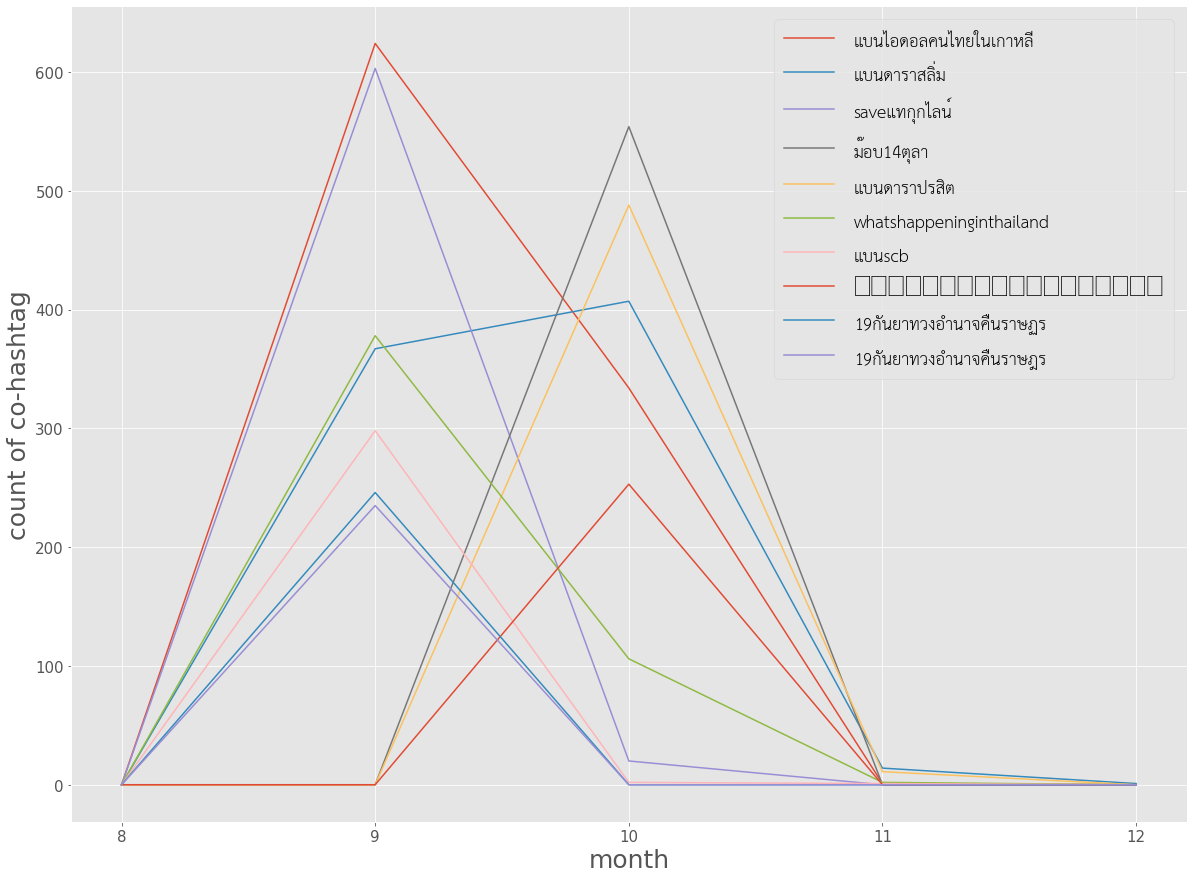

In [22]:
### plot time series ###

start_m = 8
xs = list(range(start_m, 13))

fig = plt.figure(figsize=(20,15))

for tag, count in tqdm(hashtag_counter.most_common(11)[1:]): # exclude original hashtag
    counts = []  
    for m in range(start_m, 13):
        count = 0
        thismonth_df = df[df.date.dt.month == m]
        for i, row in thismonth_df.iterrows():
            if tag in row['hashtags']:
                count += 1
        counts.append(count)

    plt.plot(xs, counts, label=tag)

plt.xticks(xs, size=15)
plt.yticks(size=15)
plt.legend(prop=font_label)
plt.xlabel('month', size=25)
plt.ylabel('count of co-hashtag', size=25)
plt.show()

# LDA

In [14]:
%%time

##### TRAIN #####

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 18274/18274 [00:00<00:00, 42124.22it/s]


CPU times: user 1min 52s, sys: 793 ms, total: 1min 53s
Wall time: 1min 56s


In [15]:
# Save  & Load

temp_file = datapath(f.replace('tweets/','').replace('_tokenized.json',''))
lda.save(temp_file)
#lda = LdaModel.load(temp_file)

In [16]:
### print result of keywords ###
print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

|rank|topic 1||topic 2||topic 3||topic 4||topic 5||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|แทกุก|0.053|แบน|0.065|ไลน์|0.063|แบน|0.064|แบน|0.139|
|2|ไลน์|0.053|แทกุก|0.044|แทกุก|0.063|แทกุก|0.053|ไลน์|0.114|
|3|แบน|0.050|ไลน์|0.044|แบน|0.054|ไลน์|0.052|แทกุก|0.114|
|4|คน|0.034|คืน|0.037|รัก|0.052|เค้า|0.035|ไทย|0.018|
|5|ที่จะ|0.032|อำนาจ|0.036|ตัวเอง|0.026|ออกมา|0.032|ดารา|0.017|
|6|เค้า|0.029|ทวง|0.035|เต|0.020|คน|0.020|เกาหลี|0.015|
|7|เลือก|0.028|กันยา|0.031|แบ|0.018|ดี|0.018|นอ|0.015|
|8|ออกมา|0.026|ตุลา|0.024|ลิ|0.017|ทำ|0.016|อิก|0.015|
|9|จ่าย|0.013|ราษฎร|0.023|นล์|0.015|เลิก|0.016|คนไทย|0.014|
|10|แฟนคลับ|0.013|ม็อบ|0.019|ประเทศ|0.015|ด่า|0.013|คน|0.013|


In [17]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet.reset_index(drop=True)
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1).reset_index(drop=True)

result_df

,0,1,2,3,4,topic,tweet,date
0,0.000000,0.000000,0.000000,0.507511,0.463657,3,แต่กุไม่เข้าใจพวกที่แบนแทกุกไลน์ แบนวันไชน่าแต...,2020-12-30 09:00
1,0.015565,0.015484,0.015533,0.209138,0.744280,4,สรุปเป้าหมายประชาธิปไตยของชาวเห็บเตี้ยนคือแบนแ...,2020-12-29 22:00
2,0.138726,0.179961,0.281389,0.000000,0.390112,4,เอาไรมากกุไปม็อบมาทุกครั้งกลับมานึกว่าจะเจอมูฟ...,2020-12-29 16:00
3,0.017032,0.016776,0.133454,0.270910,0.561829,4,กุยังแบนแทกุกไลน์​อยู่แต่ไม่ได้เข้าไปยุ่งประจา...,2020-12-29 15:00
4,0.146627,0.091056,0.000000,0.280210,0.473698,4,โค้ดสำหรับเชคว่าใครหยิกหลังน้อง เช่น แบน+แทกุก...,2020-12-27 22:00
...,...,...,...,...,...,...,...,...
18269,0.000000,0.148510,0.000000,0.534434,0.303605,3,แต่กุขำ คนแบนติ่งคู่จิ้น อิติ่งคู่จิ้นก็ออกมาด...,2020-08-31 16:00
18270,0.010089,0.010108,0.633763,0.010118,0.335922,2,แบนแทกุกไลน์ แบนแบมๆ แบนลิซ่า แบนเตน แบนนิชคุน...,2020-08-31 14:00
18271,0.014458,0.014333,0.383636,0.014556,0.573017,4,อยากแบนแทกุกไลน์ กุอันฟอลลิซแบมไปแล้ว แต่กับเต...,2020-08-29 16:00
18272,0.010092,0.522511,0.290959,0.166243,0.010196,1,ก่อนหน้านี้ชวนกันแบนแทกุกไลน์ แต่พอบพ.ออกเพลงก...,2020-08-28 17:00


In [18]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].sample(10).iterrows():
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

|tweet|topic|prob of 1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|ไม่ได้อะไรกับการแบนนะ แต่แท๊กขึ้นเทรนทุกครั้งช่วงมีม๊อบ งวดที่แล้วมีแต่แท็กเรื่องนี้ กลายเป็นว่าเรื่องแกนนำเกิดไรขึ้นบ้างหาอ่านยากมาก อยากให้ทุกคนโฟกัสแต่พอดีค่ะ #แบนแทกุกไลน์|4|0.254|0.142|0.011|0.429|0.164|
|เสียงของพวกเขามีความหมายมากๆ และดังกว่าพวกเราหลายคน แต่เค้าเลือกที่จะอิกนอ ปิดหูปิดตาเพิกเฉย ฟค.ไม่ต้องมาอ้างนะคะว่าค่ายสั่งหรือเหตุผลขิงข่ายอมรับเถอะค่ะ ไปพักค่ะ  #แบนแทกุกไลน์|1|0.380|0.000|0.000|0.334|0.269|
|รู้ได้ยังไงก่อนว่ามีกฎข้อนี้จริงๆแล้วทำไมตอนวันไชน่ามีคนออกมาแสดงจุดยืนหล่ะ #แบนแทกุกไลน์  https://t.co/YD7HCg8lkt|5|0.016|0.016|0.016|0.451|0.502|
|#แบนแทกุกไลน์  https://t.co/YeRkpgvmCw|5|0.051|0.051|0.051|0.051|0.797|
|ในวันที่เราได้ประชาธิปไตยคืนมา กุจะรอดูวันที่แทกุกไลน์และคนไทยที่ไปดังในต่างประเทศแล้วอิกนอร์บินกลับไทยค่ะ อยากจะรอดูว่าจะมีสีหน้ายิ้มแย้มแจ่มใสขนาดไหนตอนกลับประเทศบ้านเกิดในวันที่ประเทศไทยเป็นของประชาชนแต่พวกคุณตอนนั้นกลับเลือกที่จะเมินเฉย #แบนแทกุกไลน์|5|0.401|0.056|0.130|0.000|0.406|
|เห็น

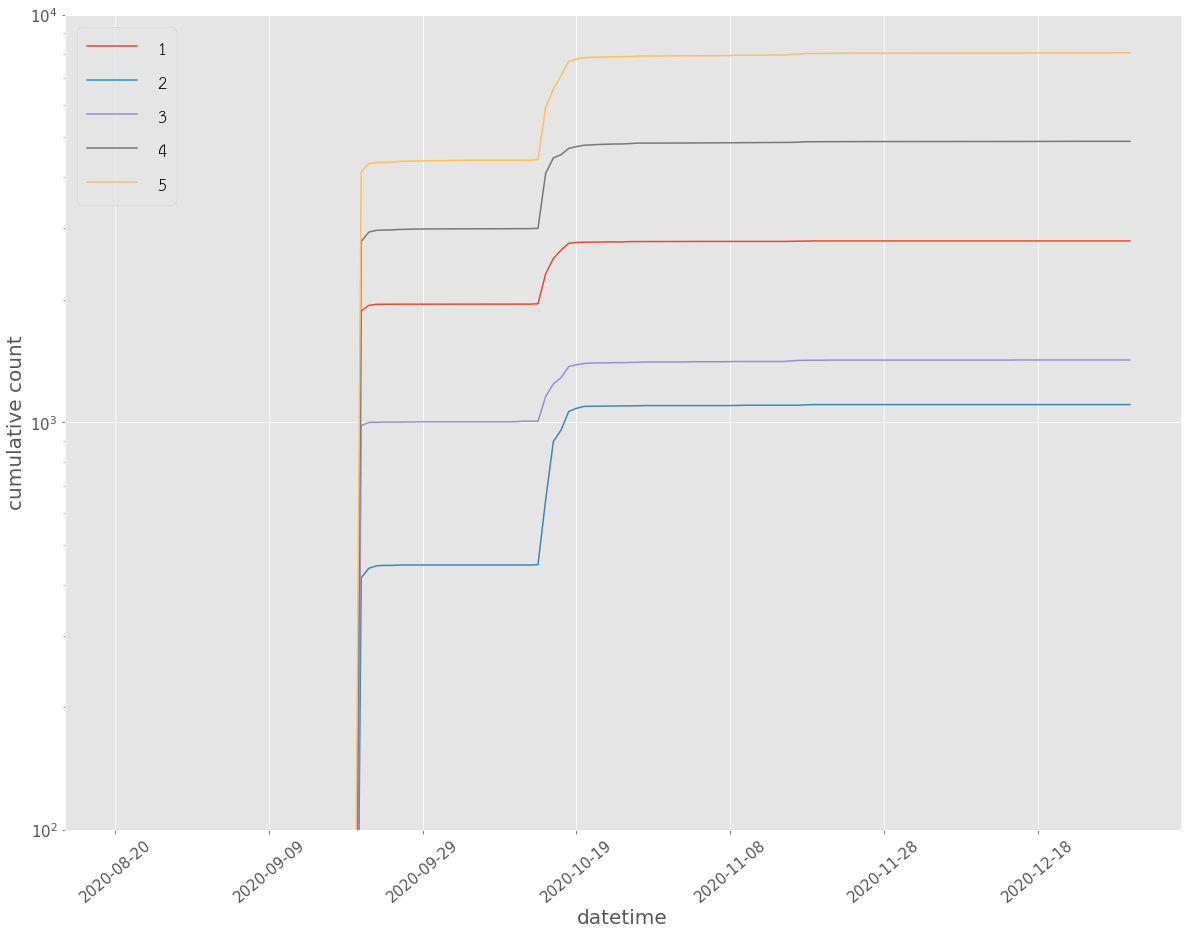

In [19]:
### plot topic time series ###

tempdf = timerange_day(df)

for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label)
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime', size=20)
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.yscale('log')
plt.ylim([100,10000])
plt.show()